# End to End Binary  text review classification
this note book is building end to end classification using tensorflow 2.x

1. Problem
Indentifiying people sentiment review using of a given text data

2. data
 data come from kaglle

3. Evaluation
file with probable sentiment review

4. Features
we are usig unstractured data, so we will use deep learning machine
we have two categorie of label: postive review and negative review


In [ ]:
 #  Unzid the uploaded data into Google Drive
 #!unzip "drive/MyDrive/Text_review/IMDB Dataset.csv.zip" -d "drive/MyDrive/Text_review/"

Archive:  drive/MyDrive/Text_review/IMDB Dataset.csv.zip
  inflating: drive/MyDrive/Text_review/IMDB Dataset.csv  


# Get our workspace ready

In [ ]:
# import tensorflow
import tensorflow as tf
print(tf.__version__)

2.19.0


In [ ]:
# import tensorflow_hub
import tensorflow_hub as hub
print(hub.__version__)
# import pandas
import pandas as pd
# import numpy
import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns

0.16.1


# Get our data ready

In [ ]:
# check our data
df = pd.read_csv("drive/MyDrive/Text_review/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# df.value_counts()

In [ ]:
df["sentiment"].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
df.isna().sum()

,0
review,0
sentiment,0


<Axes: xlabel='sentiment'>

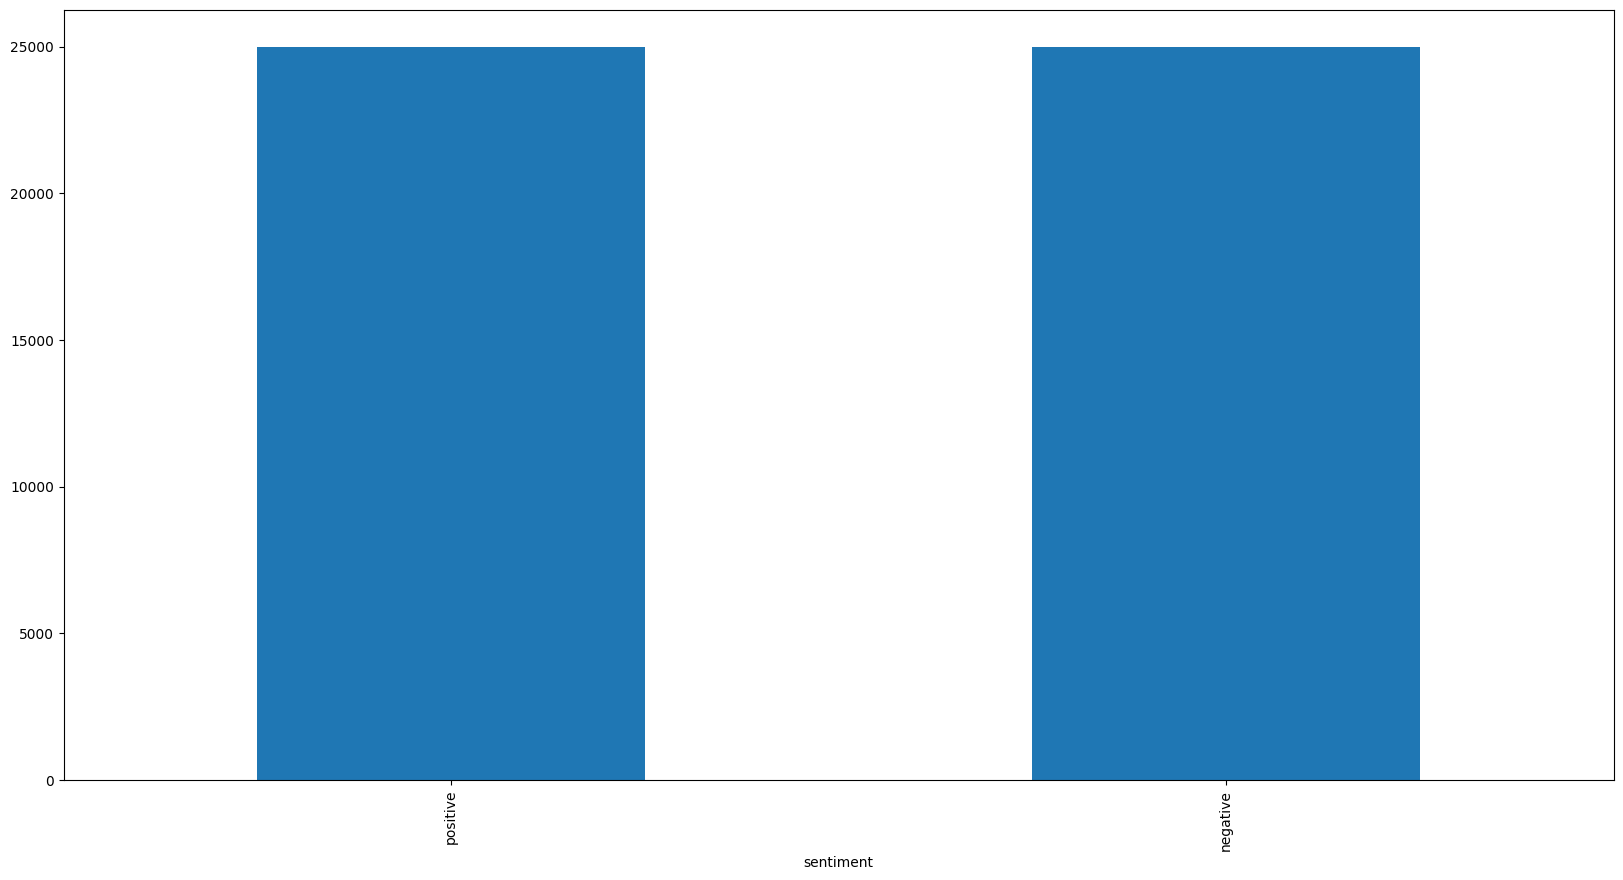

In [ ]:
df["sentiment"].value_counts().plot. bar(figsize =(20, 10))

In [ ]:
# turn  the lables into numeric format
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(df["sentiment"])  # 'negative'->0, 'positive'->1

In [ ]:
print(labels)

[1 1 1 ... 0 0 0]


In [ ]:
# let use x and y for our variable and labels
x = df["review"]
y = labels

# we are going to start with 1000 text and increase as needed

In [ ]:
# set number of image to use for experimenting
NUM_TEXT= 1000 #@param {type:"slider", min:1000, max :10000, step :1000 }

In [ ]:
# let's split our data into train and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x[:NUM_TEXT],
                                                  y[:NUM_TEXT],
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y[:NUM_TEXT])
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
from tensorflow.keras import layers
from typing import Iterable

In [ ]:
# preprocess data
def custom_standarize(text):
  # Conert to Lowercase
  text = tf.strings.lower(text)
  # RemplaceIMDB's HTML line break with space
  text = tf.strings.regex_replace(text, "<br />", " ")
  # remove remaining HTML tags
  text = tf.strings.regex_replace(text,r"<[^>]+>", " ")
  # remove URLS
  text = tf.strings.regex_replace(text, r"http\S+\www\.\s+", " ")
  # keep letter/number
  text = tf.strings.regex_replace(text, r"[^a-z0-9'?!.,]+", " ")
  # collaspe multiple space
  text = tf.strings.regex_replace(text, r"\s+", " ")
  # trim ends
  text = tf.strings.strip(text)
  return text

In [ ]:
# check the review lenght and plot it
review_lenghts = df["review"].str.split().apply(len)
# print some stats
print("Average lenght:", review_lenghts.mean())
print("Minimum lenght:", review_lenghts.min())
print("Maximum lenght:", review_lenghts.max())
print("95% lenght:", review_lenghts.quantile(0.95))


Average lenght: 231.15694
Minimum lenght: 4
Maximum lenght: 2470
95% lenght: 590.0


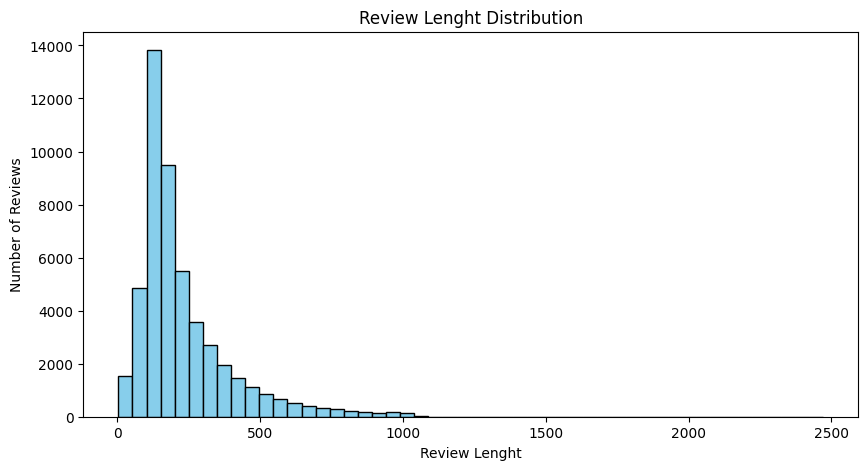

In [ ]:
# plot the review
plt.figure(figsize=(10, 5))
plt.hist(review_lenghts, bins = 50, color ="skyblue", edgecolor="black")
plt.title("Review Lenght Distribution")
plt.xlabel("Review Lenght")
plt.ylabel("Number of Reviews")
plt.show()

In [ ]:
lengths = df["review"].str.split().apply(len)
for L in [200, 256, 300, 400]:
    pct = (lengths <= L).mean() * 100
    print(f"{L:>3} tokens covers ~{pct:.1f}% of reviews")

200 tokens covers ~59.1% of reviews
256 tokens covers ~71.4% of reviews
300 tokens covers ~77.7% of reviews
400 tokens covers ~87.0% of reviews


In [ ]:
# vectorization of text data
def make_vectorizer(
    train_texts:Iterable[str],
    vocab_size:int= 30_000,
    seq_len: int = 400,
    standardize_fn = custom_standarize,
    output_mode: str ="int"
) :
   # create and adapt text vectorization
   vec = layers.TextVectorization(
       max_tokens = vocab_size,
       output_sequence_length = seq_len,
       standardize = standardize_fn,
        )
   ds = tf.data.Dataset.from_tensor_slices(train_texts)
   vec.adapt(ds)
   return vec


In [ ]:
# create a function that turn data into batch
BATCH= 64
AUTOTUNE = tf.data.AUTOTUNE
def create_data_batch(x, y= None, batch_size=BATCH, valid_data = False, test_data = False):
  """
  create a function that turn data into batch.
  if training shuft data . If valid or test do not shuffle

  """
  if test_data:
    print("creating test data batches")
    data = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(x, dtype=tf.string))
    data_batch = data.batch(batch_size).prefetch(AUTOTUNE)
    return data_batch
  elif valid_data:
    print("creating validation data batches")
    data = tf.data.Dataset.from_tensor_slices((
      tf.convert_to_tensor(x, dtype=tf.string),
      tf.convert_to_tensor(y, dtype=tf.int32)
    ))
    data_batch = data.batch(batch_size).prefetch(AUTOTUNE)
    return data_batch
  else:
    print("creating training data batches")
    data = tf.data.Dataset.from_tensor_slices((
        tf.convert_to_tensor(x, dtype=tf.string),
        tf.convert_to_tensor(y, dtype=tf.int32)
    ))
    data = data.shuffle(buffer_size = len(x))
    data_batch = data.batch(batch_size).prefetch(AUTOTUNE)
    return data_batch




In [ ]:
train_data = create_data_batch(X_train, y_train)
val_data = create_data_batch(X_val, y_val, valid_data=True)

creating training data batches
creating validation data batches


In [ ]:
# check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None,), dtype=tf.string, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None,), dtype=tf.string, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)))

In [ ]:
for text_batch, label_batch in train_data.take(1):   # take 1 batch
    print("Batch text shape:", text_batch.shape)
    print("Batch label shape:", label_batch.shape)
    print("\nExample review (first in batch):")
    print(text_batch[0].numpy().decode("utf-8"))   # decode bytes → string
    print("Label:", label_batch[0].numpy())

Batch text shape: (64,)
Batch label shape: (64,)

Example review (first in batch):
Is nothing else on TV? Are you really bored? Well, then watch Phat Beach. However, don't rent it and definitely DO NOT buy it. That would be a big mistake.<br /><br />I watched this on TV and found myself laughing at certain points. I did not laugh long and I did not laugh hard. However, there were subtle jokes and comments I laughed at. If you are looking for an extremely funny "hood" movie then watch Friday. If you are looking for a powerful emotional movie (something that this movie tries at..kind of) watch something like hoop dreams or Jason's Lyric. If you are lookin for some good black "booty" go watch a Dominique Simone porn flick, because the nudity in this movie is nearly non-existent. However, if you have nothing better to do and this is on cable, go ahead and watch it. You will be slightly amused.<br /><br />***3 out of 10***
Label: 0


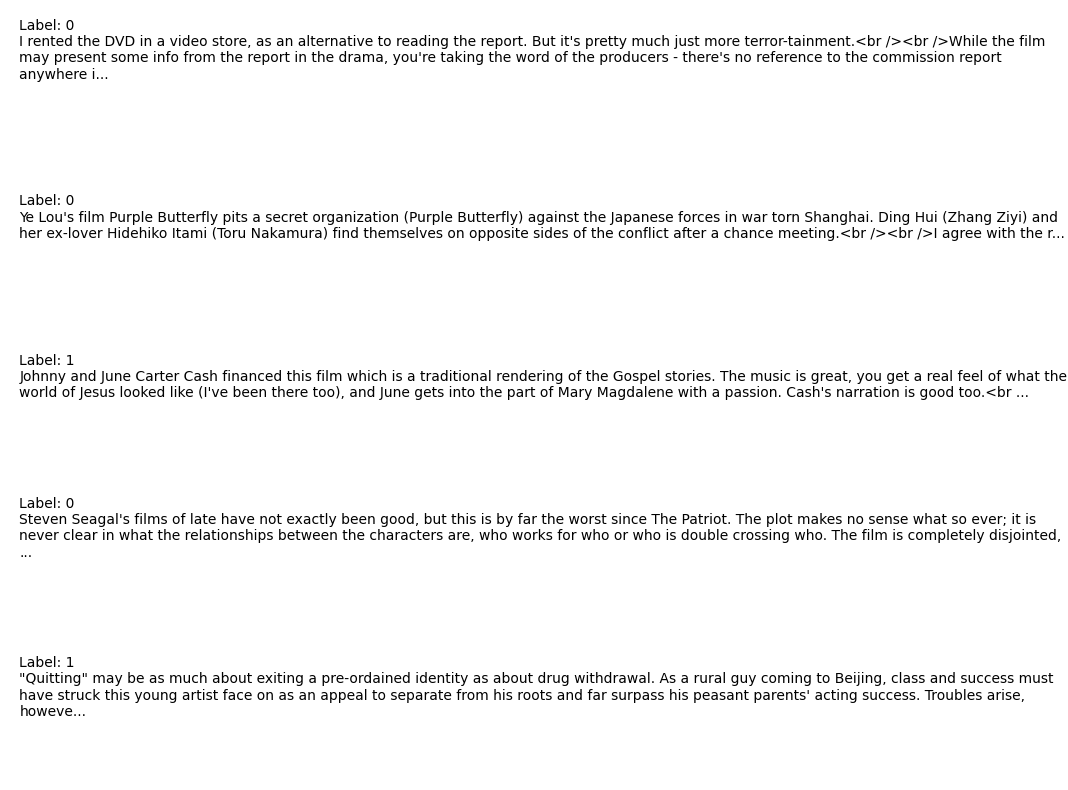

In [ ]:
import matplotlib.pyplot as plt

# Take one batch
for text_batch, label_batch in train_data.take(1):
    fig, axes = plt.subplots(5, 1, figsize=(12, 10))
    for i, ax in enumerate(axes):
        review = text_batch[i].numpy().decode("utf-8")
        label  = label_batch[i].numpy()
        ax.text(0.01, 0.5, f"Label: {label}\n{review[:300]}...",
                wrap=True, fontsize=10)
        ax.axis("off")
    plt.show()

# Build the model

In [ ]:
# set the input of the model
#INPUT_SHAPE = []
# output_shape
#OUTPUT_SHAPE =  (1, )
# model link
#MODEL_URL = "https://tfhub.dev/google/nnlm-en-dim128/2"

In [ ]:
# set the input of the model
INPUT_SHAPE = []
# output_shape
OUTPUT_SHAPE =  (1, )
# model link
MODEL_URL_1 = "https://tfhub.dev/google/universal-sentence-encoder/4"

In [ ]:
from tf_keras import layers, models, losses, optimizers
import tensorflow_hub as hub

# create function which build Keras model
def create_model(input_shape= INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL_1):
  print("Building model with:", model_url)
  model = models.Sequential([
      hub.KerasLayer(MODEL_URL_1, input_shape=INPUT_SHAPE, dtype=tf.string, trainable=False),
      layers.Dropout(0.5),
      layers.Dense(128, activation="relu"),
      layers.Dropout(0.3),
      layers.Dense(1, activation="sigmoid")
  ])

  # compile the model
  model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/universal-sentence-encoder/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256863617 (979.86 MB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 256797824 (979.61 M

In [ ]:
# load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime
from tf_keras.callbacks import TensorBoard
# let's creste our model callback
import os, datetime


# TensorBoard callback
def create_tensorboard_callback():
    logdir = os.path.join("drive/MyDrive/Text_Review/save",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return TensorBoard(log_dir=logdir)

In [ ]:
from tf_keras.callbacks import EarlyStopping
# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="max",
    restore_best_weights=True,
    min_delta=1e-4
)

# training the model

In [ ]:
# first let's create our epoch
EPOCHS = 100 #@param {type:"slider", min:10, max :100, step :10 }

In [ ]:
# let's train our model
def train_model():
  print("Training model")
  # create model
  model = create_model()
   # Create new Tensorboard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # fit ten model to the data passing it thhe callbacks we created
  model.fit(x=train_data,
            epochs= EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  return model



In [ ]:
model = train_model()

Training model
Building model with: https://tfhub.dev/google/universal-sentence-encoder/4
Epoch 1/100
13/13 [==============================] - 12s 542ms/step - loss: 0.6778 - accuracy: 0.6225 - val_loss: 0.6565 - val_accuracy: 0.7550
Epoch 2/100
13/13 [==============================] - 4s 298ms/step - loss: 0.6377 - accuracy: 0.7575 - val_loss: 0.6166 - val_accuracy: 0.8050
Epoch 3/100
13/13 [==============================] - 2s 131ms/step - loss: 0.5891 - accuracy: 0.7975 - val_loss: 0.5664 - val_accuracy: 0.8050
Epoch 4/100
13/13 [==============================] - 4s 340ms/step - loss: 0.5369 - accuracy: 0.8112 - val_loss: 0.5189 - val_accuracy: 0.8100
Epoch 5/100
13/13 [==============================] - 3s 228ms/step - loss: 0.4875 - accuracy: 0.8100 - val_loss: 0.4804 - val_accuracy: 0.8150
Epoch 6/100
13/13 [==============================] - 2s 124ms/step - loss: 0.4528 - accuracy: 0.8138 - val_loss: 0.4488 - val_accuracy: 0.8150
Epoch 7/100
13/13 [==============================] 

In [ ]:
model.save("/content/drive/MyDrive/mode/my_model.h5")

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluation and prediction

In [ ]:
val_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
predictions = model.predict(val_data, verbose = 1)
predictions

4/4 [==============================] - 0s 124ms/step


array([[0.99066377],
       [0.55786264],
       [0.2167953 ],
       [0.34840018],
       [0.7770625 ],
       [0.95499355],
       [0.9897624 ],
       [0.34524485],
       [0.42968014],
       [0.02838824],
       [0.6721453 ],
       [0.8154854 ],
       [0.59714305],
       [0.13630967],
       [0.1686374 ],
       [0.04976717],
       [0.8351156 ],
       [0.08481938],
       [0.50751823],
       [0.3082185 ],
       [0.8491776 ],
       [0.24320517],
       [0.96889544],
       [0.2522638 ],
       [0.90466607],
       [0.91788995],
       [0.9871794 ],
       [0.8122276 ],
       [0.1205891 ],
       [0.97580963],
       [0.59983397],
       [0.18700026],
       [0.6720302 ],
       [0.45235562],
       [0.50769085],
       [0.05853237],
       [0.5147886 ],
       [0.03559624],
       [0.05482851],
       [0.2508571 ],
       [0.22130024],
       [0.97171396],
       [0.77942526],
       [0.9025655 ],
       [0.89081633],
       [0.4584146 ],
       [0.0380279 ],
       [0.410

In [ ]:
predictions.shape

(200, 1)

In [ ]:
import numpy as np
pred_labels = (predictions >0.5).astype(int)
print(labels[:10])

[1 1 1 0 1 1 1 0 0 1]


In [ ]:
import pandas as pd
df = pd.DataFrame({
    "True Label": y_val.reshape(-1),
    "Predicted Label": pred_labels.reshape(-1)
})
print(df.head(10))

   True Label  Predicted Label
0           1                1
1           0                1
2           0                0
3           0                0
4           1                1
5           1                1
6           1                1
7           1                0
8           0                0
9           0                0


# train on all the data

In [ ]:
len(x), len(y)

(50000, 50000)

In [ ]:
# creation of btachn with full data
full_data = create_data_batch(x, y)

creating training data batches


In [ ]:
full_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
full_model = create_model()

Building model with: https://tfhub.dev/google/universal-sentence-encoder/4


In [ ]:
# create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all data, so we can,t monitor validation acuraccy
full_model_early_stopping = EarlyStopping(monitor="accuracy",
                                         patience=3,
                                         restore_best_weights=True)

In [ ]:
# Fit the model the full data
full_model.fit(x=full_data,
               epochs = EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])
model.save("/content/drive/MyDrive/mode/my_full_model.keras")

Epoch 1/100
782/782 [==============================] - 103s 126ms/step - loss: 0.4198 - accuracy: 0.8097
Epoch 2/100
782/782 [==============================] - 99s 127ms/step - loss: 0.3877 - accuracy: 0.8237
Epoch 3/100
782/782 [==============================] - 96s 123ms/step - loss: 0.3865 - accuracy: 0.8255
Epoch 4/100
782/782 [==============================] - 93s 119ms/step - loss: 0.3839 - accuracy: 0.8252
Epoch 5/100
782/782 [==============================] - 98s 125ms/step - loss: 0.3808 - accuracy: 0.8267
Epoch 6/100
782/782 [==============================] - 95s 121ms/step - loss: 0.3750 - accuracy: 0.8307
Epoch 7/100
782/782 [==============================] - 101s 130ms/step - loss: 0.3753 - accuracy: 0.8317
Epoch 8/100
782/782 [==============================] - 96s 123ms/step - loss: 0.3701 - accuracy: 0.8345
Epoch 9/100
782/782 [==============================] - 96s 123ms/step - loss: 0.3676 - accuracy: 0.8354
Epoch 10/100
782/782 [==============================] - 93s 11